In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import nipy
from nipy.labs.mask import compute_mask
from skimage import exposure, img_as_float
from skimage.exposure import rescale_intensity, adjust_gamma, equalize_adapthist
from scipy import stats
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'DK41'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
MASK = os.path.join(DIR, 'preps','thumbnail_masked')
masks = sorted(os.listdir(MASK))
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import trim_edges, create_mask_pass1, fix_with_fill, equalized
from utilities.sqlcontroller import SqlController
sqlController = SqlController(animal)

Connecting dklab@192.168.1.12:3306


In [ ]:
bad = []
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad]
print(f'Need to manually fix {len(bads)} files or %{100*len(bads)/len(files)}')

100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


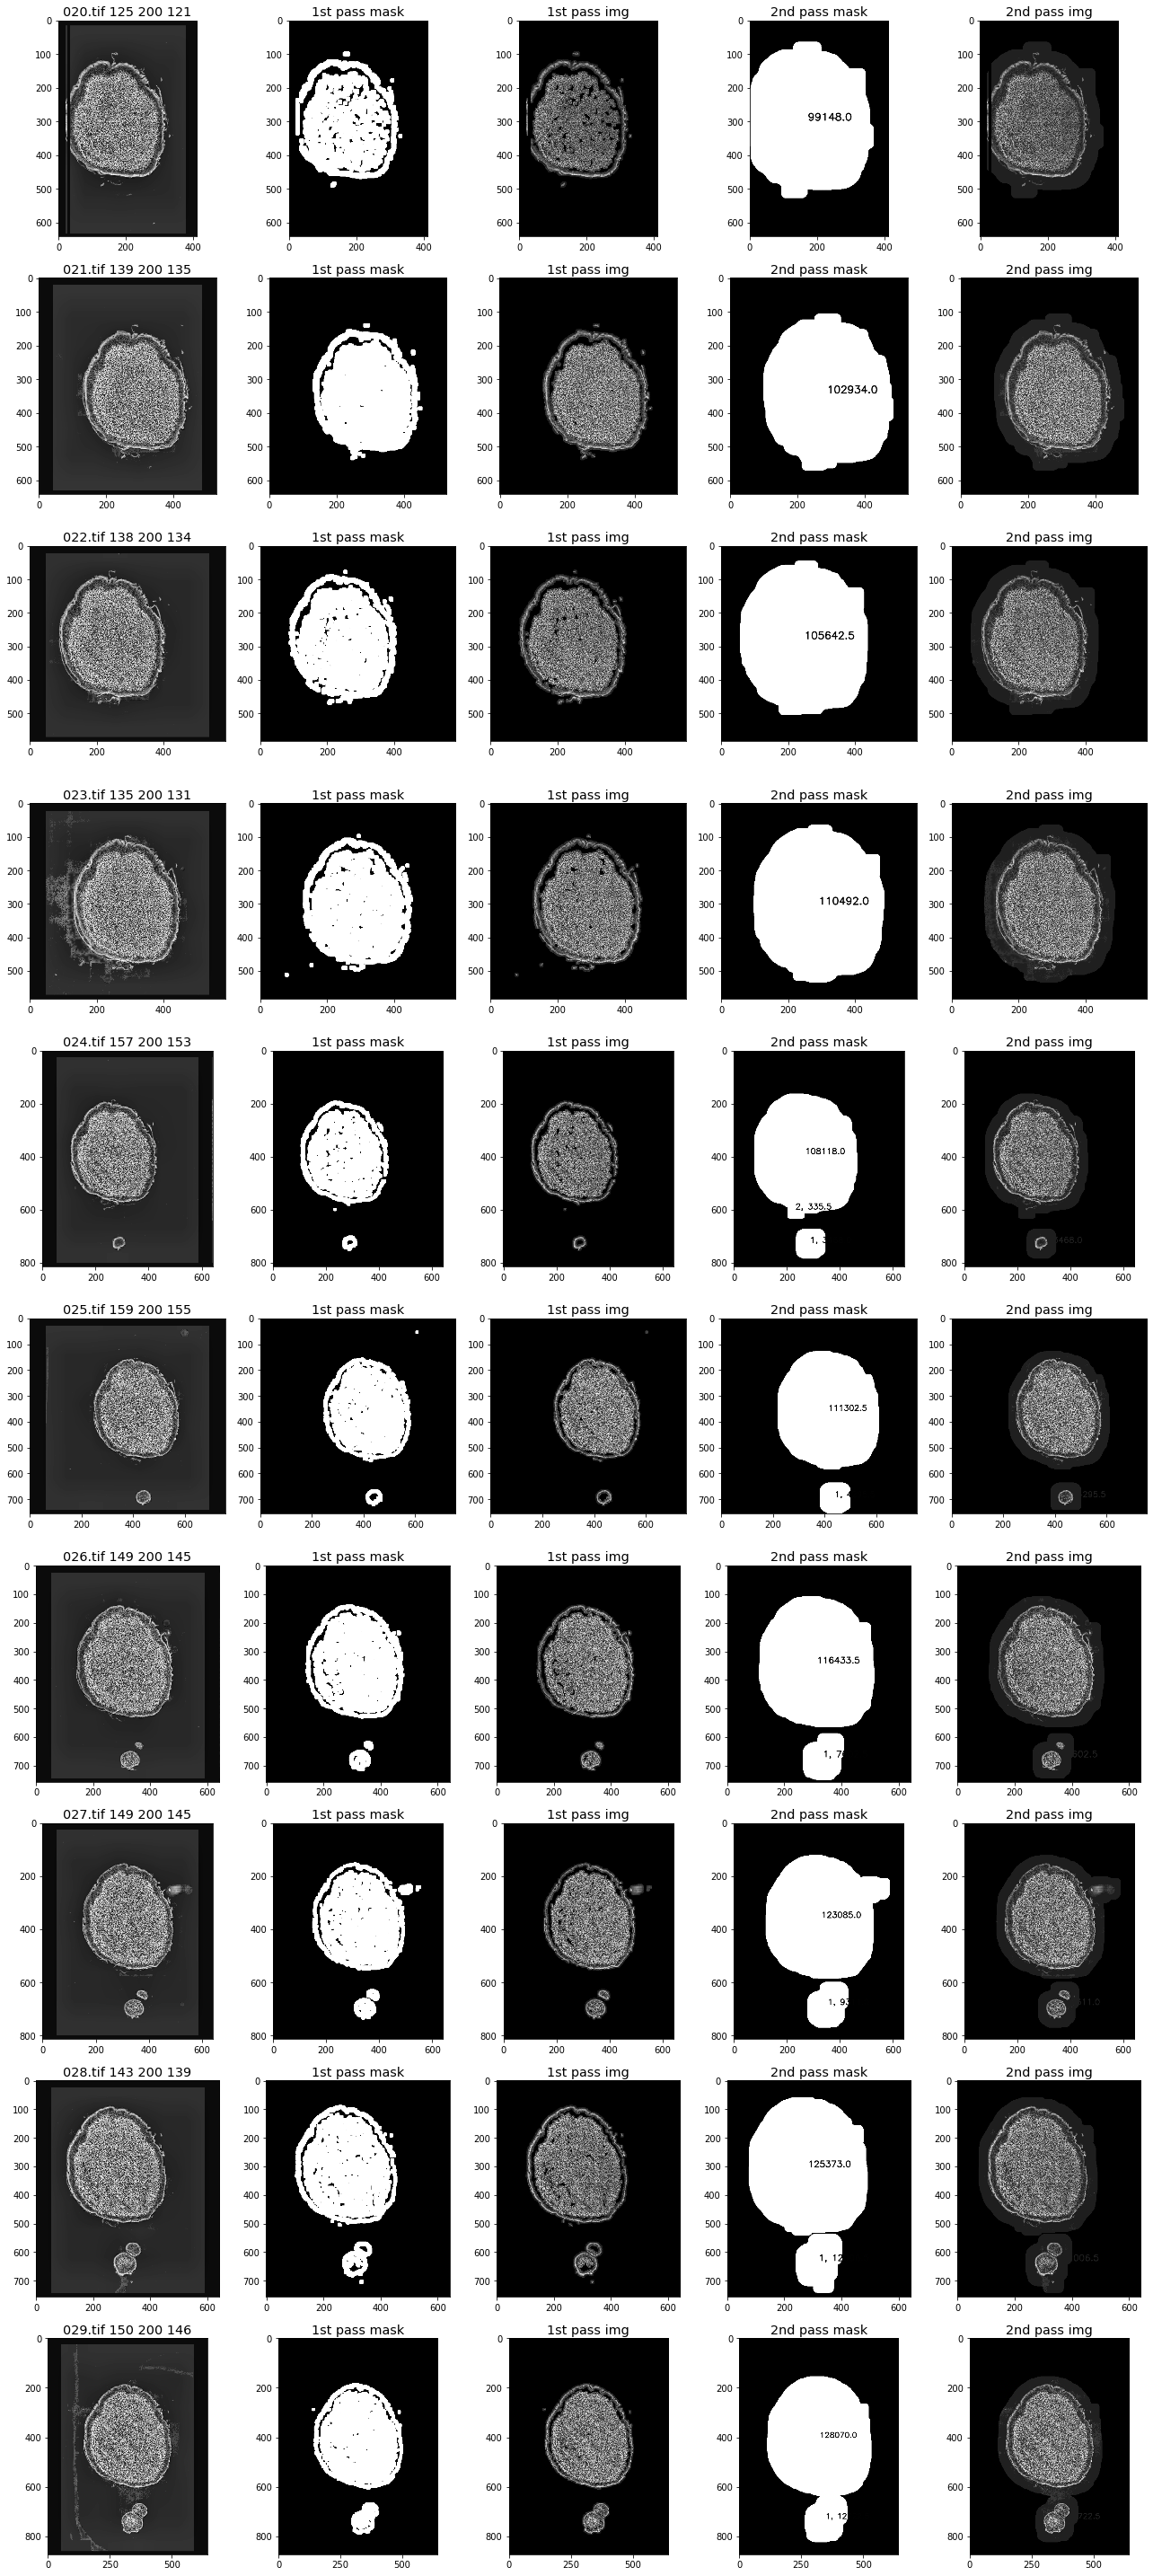

In [5]:
names = []
norms = []
masks1 = []
passes1 = []
masks2 = []
passes2 = []
start, finish = (20,30)
lowVal, highVal, threshold = (0,0,0)

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img = trim_edges(img)
    normed = equalized(img)
    img8 = (normed/256).astype('uint8')

    #gamma_corrected = exposure.adjust_gamma(img, 2)
    norms.append(normed)
    mask1 = create_mask_pass1(img)
    pass1 = cv2.bitwise_and(img, img, mask=mask1)
    masks1.append(mask1)    
    passes1.append(pass1)
    ## pass2
    pass2 = cv2.GaussianBlur(pass1,(33,33),0)
    mask2, lowVal, highVal, threshold = fix_with_fill(pass2, debug=True)
    #mask2 = mask1
    pass2 = cv2.bitwise_and(img, img, mask=mask2)
    masks2.append(mask2)
    passes2.append(pass2)
    name = f'{file} {round(lowVal)} {round(highVal)} {round(threshold)}'
    names.append(name)
    
fig, ax = plt.subplots(nrows=len(masks1), ncols=5, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask1, pass1, mask2, pass2 in zip(names, norms, masks1, passes1, masks2, passes2):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('1st pass mask')
    ax[i,1].imshow(mask1, cmap="gray")
    ax[i,2].set_title('1st pass img')
    ax[i,2].imshow(pass1, cmap="gray")
    ax[i,3].set_title('2nd pass mask')
    ax[i,3].imshow(mask2, cmap="gray")
    ax[i,4].set_title('2nd pass img')
    ax[i,4].imshow(pass2, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=False)
plt.tight_layout()
plt.show()

In [143]:
def get_binary_mask(img):
    '''
    blur,
    OTSUs threhold,
    open/close
    '''
    kernel_size = (199,199)
    blurred_img = cv2.GaussianBlur(img,kernel_size, 0)
    gray_img = blurred_img.copy()
    thresh = 80 # initial value, but OTSU calculates it 
    ret, otsu = cv2.threshold(gray_img, thresh, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ksize = 50
    kernel = np.ones((ksize,ksize),np.uint8)
    closed_mask = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)
    return closed_mask

Text(0.5, 1.0, 'fixed')

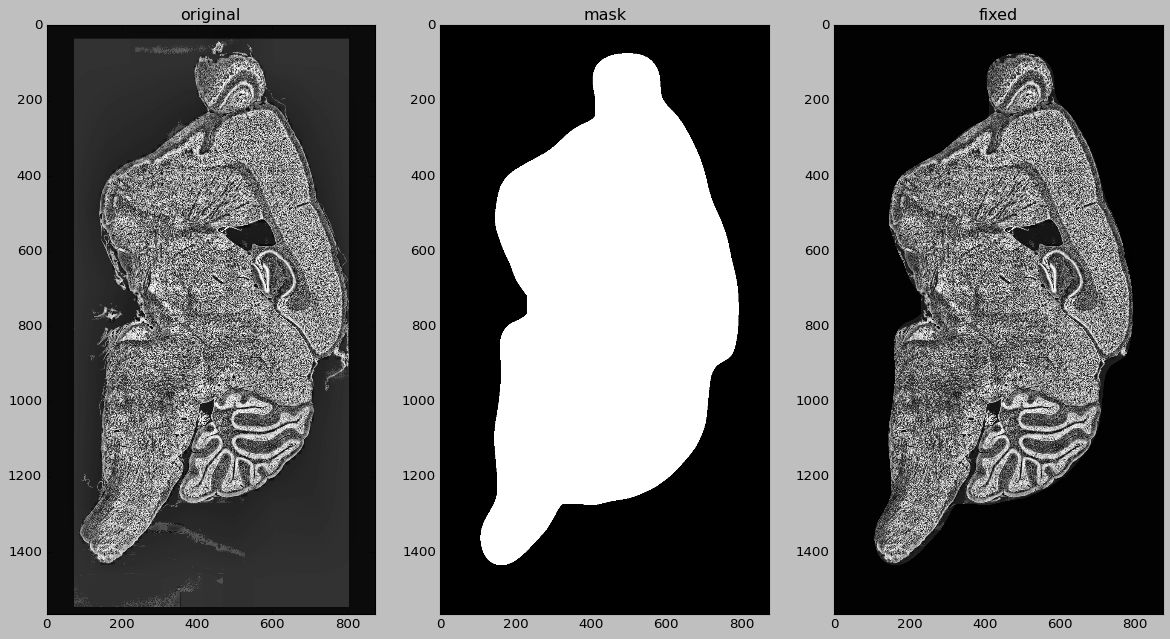

In [146]:
# 181, very dark
# 381, kinda light
file = '181.tif' 
infile = os.path.join(INPUT, file)
img = io.imread(infile)
img = trim_edges(img)
normed = equalized(img)
mask = get_binary_mask(normed)
fixed = cv2.bitwise_and(img, img, mask=mask)
fixed = equalize_adapthist(fixed)
# figure size in inches optional
rcParams['figure.figsize'] = 18 ,18
fig, ax = plt.subplots(1,3)
ax[0].imshow(normed, cmap="gray");
ax[0].set_title('original')
ax[1].imshow(mask, cmap="gray");
ax[1].set_title('mask')
ax[2].imshow(fixed, cmap="gray");
ax[2].set_title('fixed')
